# Seasonal Decomposition of Time Series

See more in detail how to perform time series analysis and forecasting with Python in [this blog](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)

**Applications**
* Anomaly detection: Analyse rare events not due to bussiness trend or seasonality
* Time series forecast: Fit a model with historical data and predict future events

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import scipy.stats as st
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

!pip install seaborn==0.9.0

import warnings
warnings.simplefilter(action='ignore', category=[FutureWarning])

In [2]:
def plot_long_time_series(data, x, y, label=None, palette=None, period=10):
    # Visualize annotation
    fig=plt.figure(figsize=(15,5))
    if label:
        ax = sns.pointplot(x=x, y=y, data=data.loc[::period], hue=label, palette=palette)
    else:
        ax = sns.pointplot(x=x, y=y, data=data.loc[::period])
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % period == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    _=plt.legend()
    _=plt.xticks(rotation=90)

## Extract stock market time series of index "S&P 500" from Yahoo Finance 

See how to download Yahoo Finance data with Pandas [here](https://pypi.org/project/fix-yahoo-finance/)

In [3]:
#Import dataframe with the new column short_date

data= pd.read_csv('/Users/blancacrosguardia/Desktop/all_women_in_tech/project_II/notebooks_csv/sellers_items_df.csv')

In [4]:
data.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,year,month,short_date
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,2017-08-25 20:50:19,106.2,9.56,2017,8,8/2017
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,2017-05-11 16:25:11,101.7,15.92,2017,5,5/2017


In [5]:
#Selection groupby of order_items and short_date. Variables that will be plotted as plot_long_time_series
data_date = data[['order_item_id','short_date']].groupby('short_date', as_index=False).count()

In [6]:
data_date.head()

,short_date,order_item_id
0,1/2017,681
1,1/2018,7492
2,10/2016,365
3,10/2017,5189
4,11/2017,7355


In [7]:
#Transformation to datetime
data_date['short_date'] = pd.to_datetime(data_date['short_date'],format='%m/%Y',utc=False)


In [8]:
#Check the unique values from short_date column
data_date['short_date'].unique()

array(['2017-01-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2016-10-01T00:00:00.000000000', '2017-10-01T00:00:00.000000000',
       '2017-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000',
       '2017-12-01T00:00:00.000000000', '2017-02-01T00:00:00.000000000',
       '2018-02-01T00:00:00.000000000', '2020-02-01T00:00:00.000000000',
       '2017-03-01T00:00:00.000000000', '2018-03-01T00:00:00.000000000',
       '2017-04-01T00:00:00.000000000', '2018-04-01T00:00:00.000000000',
       '2020-04-01T00:00:00.000000000', '2017-05-01T00:00:00.000000000',
       '2018-05-01T00:00:00.000000000', '2017-06-01T00:00:00.000000000',
       '2018-06-01T00:00:00.000000000', '2017-07-01T00:00:00.000000000',
       '2018-07-01T00:00:00.000000000', '2017-08-01T00:00:00.000000000',
       '2018-08-01T00:00:00.000000000', '2016-09-01T00:00:00.000000000',
       '2017-09-01T00:00:00.000000000', '2018-09-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [9]:
#create a list with the outliers to remove
outliers=['2020-02-01T00:00:00.000000000','2018-03-01T00:00:00.000000000',
          '2018-04-01T00:00:00.000000000','2018-09-01T00:00:00.000000000','2020-04-01T00:00:00.000000000']

In [10]:
#Create a dataframe with the condition to select the outliers list column to not include on the lon_time_series_plot
non_outliers = data_date[~data_date['short_date'].isin(outliers)]


In [11]:
#Create a list of the whole months to include on the lon_time_series_plot.
list_dates =  pd.date_range(start='2016-08-31', periods=25, freq='M')

#convert that list to a dataframe
a = pd.DataFrame({'short_date':list_dates})

In [12]:
#check the type of the dataframe
(a['short_date'])

0    2016-08-31
1    2016-09-30
2    2016-10-31
3    2016-11-30
4    2016-12-31
5    2017-01-31
6    2017-02-28
7    2017-03-31
8    2017-04-30
9    2017-05-31
10   2017-06-30
11   2017-07-31
12   2017-08-31
13   2017-09-30
14   2017-10-31
15   2017-11-30
16   2017-12-31
17   2018-01-31
18   2018-02-28
19   2018-03-31
20   2018-04-30
21   2018-05-31
22   2018-06-30
23   2018-07-31
24   2018-08-31
Name: short_date, dtype: datetime64[ns]

In [13]:
#transfrom the date format to have the same one that non_outliers and to be able to merge them
new_times = a['short_date'].dt.to_period('M').astype(str)+'-'+'01'

In [14]:
#transform the new_times to dataframe
new_times_new = pd.DataFrame({'short_date':new_times.values})

In [15]:
#check the dtype of new_times_new
new_times_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 1 columns):
short_date    25 non-null object
dtypes: object(1)
memory usage: 280.0+ bytes


In [16]:
#Tranform the new_time_new from str to datetime
new_times_new['short_date'] = pd.to_datetime(new_times_new['short_date'],format='%Y/%m',utc=False)


In [17]:
#recheck that new_times_new is now a datetime type
new_times_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 1 columns):
short_date    25 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 280.0 bytes


In [18]:
#merge the two dataframes that will have the whole months to then visualize it
new_new_df = pd.merge(new_times_new, non_outliers, on='short_date', how='outer').fillna(0).sort_values(by='short_date')


In [22]:
new_new_df.to_csv('/Users/blancacrosguardia/Desktop/all_women_in_tech/project_II/notebooks_csv/new_new_df.csv', index=False, encoding='utf-8')



No handles with labels found to put in legend.


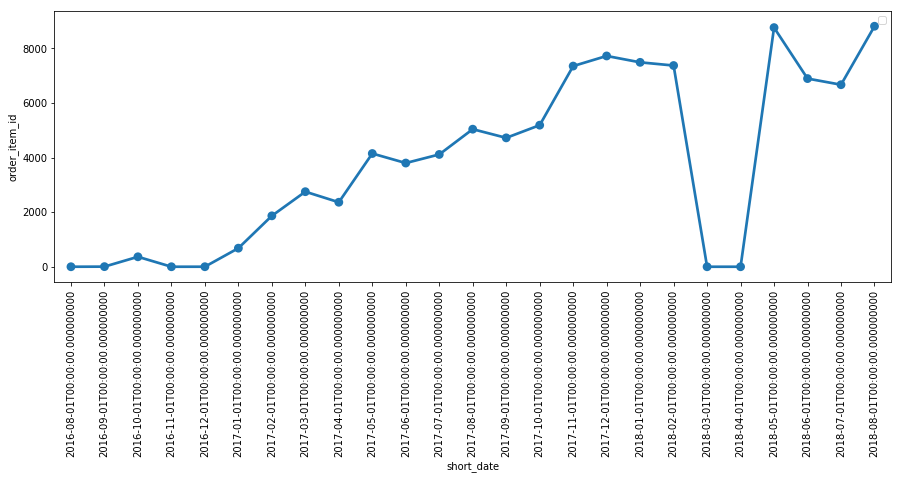

In [19]:
# Visualize the evolution over time of the close stock market prices over the years 
plot_long_time_series(new_new_df, 'short_date', 'order_item_id', label=None, palette=None, period=1)

## Decompose the time series in Trend, Seasonal and Residuals

**Parameters**
* model
  * additive Y[t] = T[t] + S[t] + e[t]
  * multiplicative Y[t] = T[t] * S[t] * e[t]
* freq
  * number of days to consider to average for the trend extrapolation calculation
  
  Seasonality is calculated by a convolution filter with a linear kernel. You can learn more about it [here](https://www.sciencedirect.com/topics/computer-science/convolution-filter).

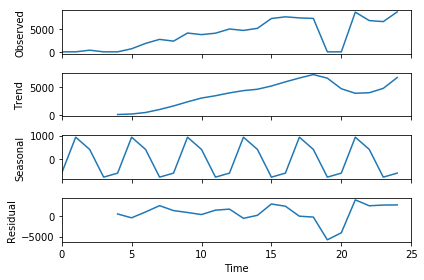

In [25]:
# Visualize the results for different frequency times (see seasonal_decompose from statsmodels)
#old example#close_prices = data['Close'].tolist() 
sales_n = new_new_df['order_item_id'].tolist() #select the dataframe and column of orders as tolist
decomposition = sm.tsa.seasonal_decompose(sales_n, freq=4, model='additive', two_sided=False)
fig = decomposition.plot()
plt.show()

In [26]:
# Store list of values of the 1) trend 2) seasonal and 3) residuals
# Notice that in the list of trend and residuals, at the beginning and at the end values are Nulls
# because there was no previous data to learn from
trend = decomposition.resid
seasonal = decomposition.seasonal
residuals = decomposition.resid

In [27]:
trend

array([         nan,          nan,          nan,          nan,
         498.278125,  -431.059375,  1000.815625,  2531.215625,
        1333.528125,   865.940625,   360.565625,  1439.965625,
        1689.153125,  -559.934375,   178.940625,  2943.465625,
        2402.653125,   -37.434375,  -254.559375, -5806.534375,
       -4092.846875,  3954.190625,  2505.940625,  2683.590625,
        2719.278125])

In [28]:
seasonal

array([-589.653125,  934.934375,  415.809375, -761.090625, -589.653125,
        934.934375,  415.809375, -761.090625, -589.653125,  934.934375,
        415.809375, -761.090625, -589.653125,  934.934375,  415.809375,
       -761.090625, -589.653125,  934.934375,  415.809375, -761.090625,
       -589.653125,  934.934375,  415.809375, -761.090625, -589.653125])

If you want to learn more about Time Series predictive models check this [video](https://www.youtube.com/watch?v=d4Sn6ny_5LI) out, you will get there!

# T-test 

For a better understanding of T-test and Z-test watch this [video](https://www.youtube.com/watch?v=QZ7kgmhdIwA).

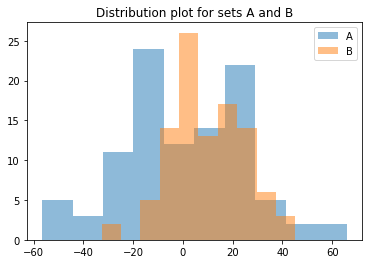

In [28]:
# Build datasets
mu = 0
sigma = 25
n_bins = 50
x = np.random.normal(mu, sigma, size=100)

mu = 10
sigma = 15
n_bins = 50
x2 = np.random.normal(mu, sigma, size=100)

_=plt.hist(x, alpha=0.5)
_=plt.hist(x2, alpha=0.5)
_=plt.legend(["A", "B"])
_=plt.title("Distribution plot for sets A and B")

## Independent T-test

In [29]:
# calculate means
mean1, mean2 = np.mean(x), np.mean(x2)

# calculate standard errors
se1, se2 = st.sem(x), st.sem(x2)

# standard error on the difference between the samples
sed = np.sqrt(se1**2.0 + se2**2.0)

# calculate the t statistic
t_stat = (mean1 - mean2) / sed

# degrees of freedom
df = len(x) + len(x2) - 2

# calculate the critical values for a confidence interval of 95%
significance_level = 0.05

# At what point is the 2.5% percentile?
t_025 = st.t.ppf(significance_level/2, df)

# At what point is the 97.5% percentile?
t_975 = st.t.ppf(1 - significance_level/2, df)

# calculate the p-value
p = (1.0 - st.t.cdf(abs(t_stat), df)) * 2.0

print("t-value: {:.4f}\ndegrees of freedom: {}\nlower critical value: {:.4f}\nupper critical value: {:.4f}\np-value: {:.7f}".format(t_stat, df, t_025, t_975, p))

t-value: -3.2309
degrees of freedom: 198
lower critical value: -1.9720
upper critical value: 1.9720
p-value: 0.0014453


## Visualize results

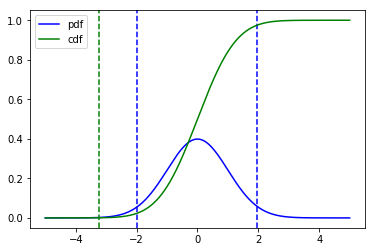

In [30]:
# Visualize t-statistics
x = np.linspace(-5, 5, 5000)
mu = 0
sigma = 1

y_pdf = st.norm.pdf(x, mu, sigma) # the normal pdf
y_cdf = st.norm.cdf(x, mu, sigma) # the normal cdf

# Visualize limits of the confidence interval (95%) in the t-student probability distribution
_=plt.axvline(x=t_025, color='b', linestyle='--')
_=plt.axvline(x=t_975, color='b', linestyle='--')
_=plt.plot(x, y_pdf, label='pdf', color='b')

# Plot actual t-value for the differences on the mean of the samples and the standard deviation
_=plt.axvline(x=t_stat, color='g', linestyle='--')

# Visualize the cummulative density function of probabilities from one tail of the t-student probability distribution
_=plt.plot(x, y_cdf, label='cdf', color='g')
_=plt.legend()

# Further statistical analysis tutorials

[Crash Course Statistics](https://www.youtube.com/results?search_query=crash+Course+Statistics)

Python 10 most common statistical tests [tutorial](https://www.analyticsindiamag.com/10-most-popular-statistical-hypothesis-testing-methods-using-python/)

